In [1]:
from konlpy.tag import Okt
import gensim
import sklearn
import seaborn
import os
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer


### STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

synopsis.txt 파일의 명사만 tokenize

In [6]:
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open('./synopsis/synopsis.txt', 'r', encoding='UTF8') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:
                res.append(w[0])
        tokenized.append(res)

### STEP 2. 추출된 결과로 embedding model 만들기

In [7]:
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  


In [8]:
model.wv.most_similar(positive=['영화'])

[('작품', 0.8886263370513916),
 ('다큐멘터리', 0.850175678730011),
 ('드라마', 0.8190449476242065),
 ('디지털화', 0.7961541414260864),
 ('영화로', 0.7916125655174255),
 ('형식', 0.7831249237060547),
 ('코미디', 0.7759407758712769),
 ('소재', 0.7735954523086548),
 ('감동', 0.7595661878585815),
 ('주제', 0.7555126547813416)]

In [9]:
model.wv.most_similar(positive=['사랑'])

[('첫사랑', 0.7291604280471802),
 ('행복', 0.7097011804580688),
 ('진심', 0.7033880352973938),
 ('가슴', 0.7001124024391174),
 ('애정', 0.6946796774864197),
 ('이별', 0.6898884773254395),
 ('만남', 0.6867862939834595),
 ('아르튬', 0.6800090074539185),
 ('운명', 0.6696742177009583),
 ('연애', 0.6684873104095459)]

유사한 의미를 갖는 단어가 잘 리스트업됨.

### STEP 3. target, attribute 단어 셋 만들기

In [2]:
def read_token(file_name):
    okt = Okt()
    result = []
    with open('./synopsis/'+file_name, 'r', encoding='UTF8') as fread:
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:
                    result.append((word[0])) 
    return ' '.join(result)

Target 단어셋 만들기

In [3]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [4]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [10]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옴
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옴

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬

n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어 15개 추출
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어 15개 추출
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [11]:
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [12]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


attribute 단어셋 만들기(아래 코드를 사용해 미리 tokenize해서 따로 저장해둔 파일을 불러옴)

def read_token(file_name):
    okt = Okt()
    result = []
    with open('./synopsis/'+file_name, 'r', encoding='UTF8') as fread:
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: 
                break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append(word[0])
    return ' '.join(result)


directory = './synopsis/'
file_list = os.listdir(directory)

for filename in file_list:
    if filename.endswith('.txt'):  # Process only text files
        tokenized_words = read_token(filename)

        # tokenize된 단어를 따로 저장
        output_filename = os.path.splitext(filename)[0] + '_tokenized.txt'
        with open(os.path.join(directory, output_filename), 'w', encoding='UTF8') as output_file:
            output_file.write(tokenized_words)

        print('{} saved as a new file'.format(output_filename))

In [14]:
def load_file(file_name):
    with open('./tokenized_latest/' + file_name, 'r', encoding='UTF8') as file:
        file_contents = file.read()
    return file_contents

In [15]:
import os
file_path = './tokenized_latest/'
file_list_2 = os.listdir(file_path)
file_list_2

['synopsis_action_tokenized.txt',
 'synopsis_adult_tokenized.txt',
 'synopsis_adventure_tokenized.txt',
 'synopsis_animation_tokenized.txt',
 'synopsis_art_tokenized.txt',
 'synopsis_comedy_tokenized.txt',
 'synopsis_crime_tokenized.txt',
 'synopsis_documentary_tokenized.txt',
 'synopsis_drama_tokenized.txt',
 'synopsis_etc_tokenized.txt',
 'synopsis_family_tokenized.txt',
 'synopsis_fantasy_tokenized.txt',
 'synopsis_gen_tokenized.txt',
 'synopsis_historical_tokenized.txt',
 'synopsis_horror_tokenized.txt',
 'synopsis_musical_tokenized.txt',
 'synopsis_mystery_tokenized.txt',
 'synopsis_romance_tokenized.txt',
 'synopsis_SF_tokenized.txt',
 'synopsis_show_tokenized.txt',
 'synopsis_thriller_tokenized.txt',
 'synopsis_tokenized.txt',
 'synopsis_war_tokenized.txt',
 'synopsis_western_tokenized.txt']

In [16]:
action = load_file(file_list_2[0])
adult = load_file(file_list_2[1])
adventure = load_file(file_list_2[2])
animation = load_file(file_list_2[3])
art = load_file(file_list_2[4])
comedy = load_file(file_list_2[5])
crime = load_file(file_list_2[6])
documentary = load_file(file_list_2[7])
drama = load_file(file_list_2[8])
etc = load_file(file_list_2[9])
family = load_file(file_list_2[10])
fantasy = load_file(file_list_2[11])
gen = load_file(file_list_2[12])
historical = load_file(file_list_2[13])
horror = load_file(file_list_2[14])
musical = load_file(file_list_2[15])
mystery = load_file(file_list_2[16])
romance = load_file(file_list_2[17])
SF = load_file(file_list_2[18])
show = load_file(file_list_2[19])
thriller = load_file(file_list_2[20])
synopsis = load_file(file_list_2[21])
war = load_file(file_list_2[22])
western = load_file(file_list_2[23])

In [18]:
genre = [action, adult, adventure, animation, comedy, crime, documentary, drama, etc, family, fantasy, historical, horror, musical, 
        mystery, romance, SF, show, thriller, war, western]

In [19]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [20]:
genre_name = ['액션', '성인물(에로)', '어드벤처', '애니메이션', '코미디', '범죄', '다큐멘터리', '드라마', '기타', '가족', '판타지',
              '사극', '공포(호러)', '뮤지컬', '미스터리', '멜로로맨스', 'SF', '공연', '스릴러', '전쟁', '서부극(웨스턴)']

In [21]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)): # 각 카테고리를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬
    w[i].sort(key=lambda x: x[1], reverse=True) 
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

액션: 위해, 자신, 시작, 조직, 사건, 사람, 그녀, 경찰, 전쟁, 모든, 목숨, 사실, 친구, 가족, 요원, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
어드벤처: 위해, 자신, 시작, 친구, 마을, 아버지, 영화, 아이, 사람, 여행, 세계, 앤트, 세상, 가족, 모험, 
애니메이션: 애니메이션, 국제, 영화제, 친구, 인디애니페스트, 위해, 자신, 시작, 사람, 페스티벌, 서울, 이야기, 아이, 마을, 소녀, 
코미디: 그녀, 자신, 시작, 위해, 사랑, 사람, 친구, 영화, 남자, 여자, 영화제, 가족, 과연, 마을, 사건, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 국제, 마을, 낙타, 
판타지: 자신, 그녀, 시작, 위해, 사람, 사랑, 요괴, 영화제, 이야기, 영화, 소녀, 남자, 인간, 세상, 마을, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 사람, 운명, 하선, 전쟁, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신,

그녀, 자신, 사람, 사랑 등의 단어가 여러 카테고리에 중복되어 있음.

### STEP 4. WEAT score 계산과 시각화

In [24]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

In [25]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [26]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

액션 성인물(에로) -0.36650982
액션 어드벤처 -0.14664084
액션 애니메이션 0.48966566
액션 코미디 0.05836671
액션 범죄 0.37294686
액션 다큐멘터리 0.6087195
액션 드라마 0.0426241
액션 기타 0.49217504
액션 가족 -0.12989978
액션 판타지 0.2409079
액션 사극 -0.13791703
액션 공포(호러) -0.559037
액션 뮤지컬 0.47904766
액션 미스터리 -0.7920934
액션 멜로로맨스 -0.7372755
액션 SF 0.46471867
액션 공연 0.07234243
액션 스릴러 -0.53187966
액션 전쟁 0.564034
액션 서부극(웨스턴) 0.14344484
성인물(에로) 어드벤처 0.2827909
성인물(에로) 애니메이션 0.7500182
성인물(에로) 코미디 0.57967705
성인물(에로) 범죄 0.4834145
성인물(에로) 다큐멘터리 0.8229602
성인물(에로) 드라마 0.56479514
성인물(에로) 기타 0.8104872
성인물(에로) 가족 0.28363815
성인물(에로) 판타지 0.6219545
성인물(에로) 사극 0.33603013
성인물(에로) 공포(호러) 0.18368945
성인물(에로) 뮤지컬 0.7842208
성인물(에로) 미스터리 0.030839128
성인물(에로) 멜로로맨스 -0.8568451
성인물(에로) SF 0.5603432
성인물(에로) 공연 0.49821922
성인물(에로) 스릴러 0.19062386
성인물(에로) 전쟁 0.6091736
성인물(에로) 서부극(웨스턴) 0.45721388
어드벤처 애니메이션 0.8722456
어드벤처 코미디 0.39449376
어드벤처 범죄 0.24016686
어드벤처 다큐멘터리 0.95163864
어드벤처 드라마 0.32060748
어드벤처 기타 0.8210355
어드벤처 가족 0.006476945
어드벤처 판타지 0.8034705
어드벤처 사극 0.035111994
어드벤처 공포(호러)

<AxesSubplot:>

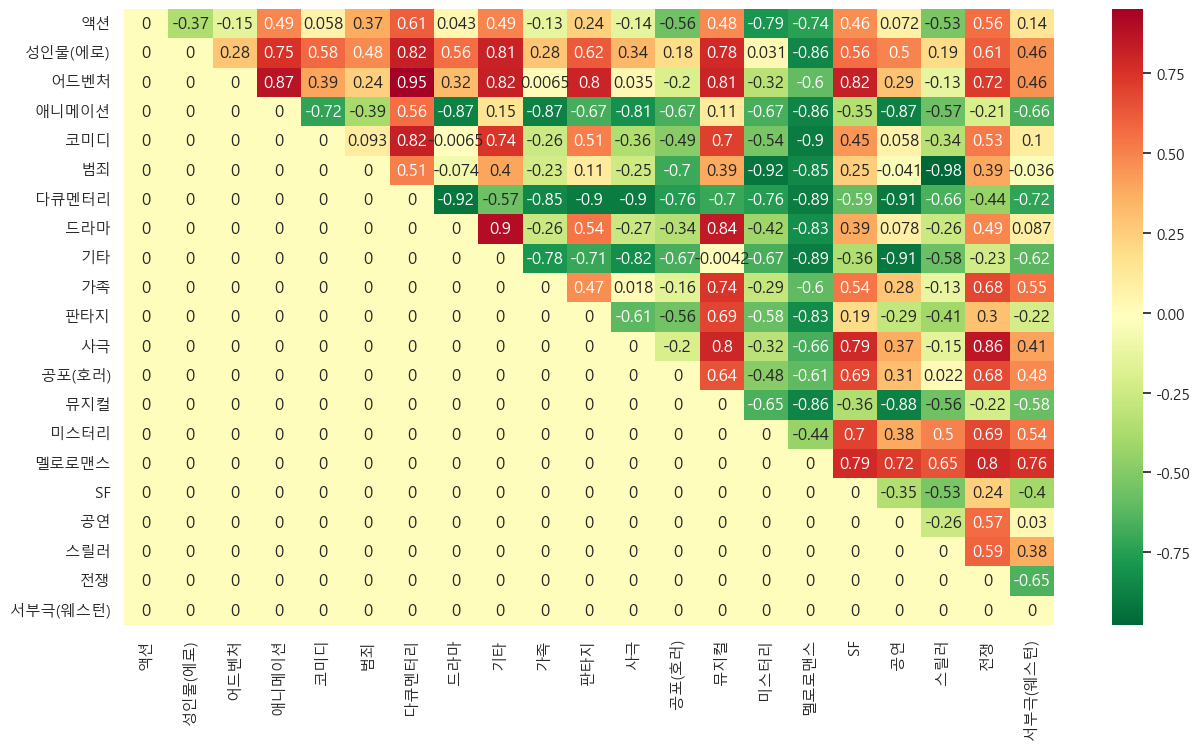

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='Malgun Gothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(15,8))

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

* 코미디의 Weat score 결과를 예로 편향성을 살펴보면, __코미디-다큐멘터리는 0.82__, __코미디-멜로로맨스는 -0.9__ 로 편향이 큼.
* X = 예술영화,  Y = 일반영화, A = 코미디, B = 다큐멘터리 or 멜로로맨스<br>

__1. 코미디-다큐멘터리 0.82__ <br>
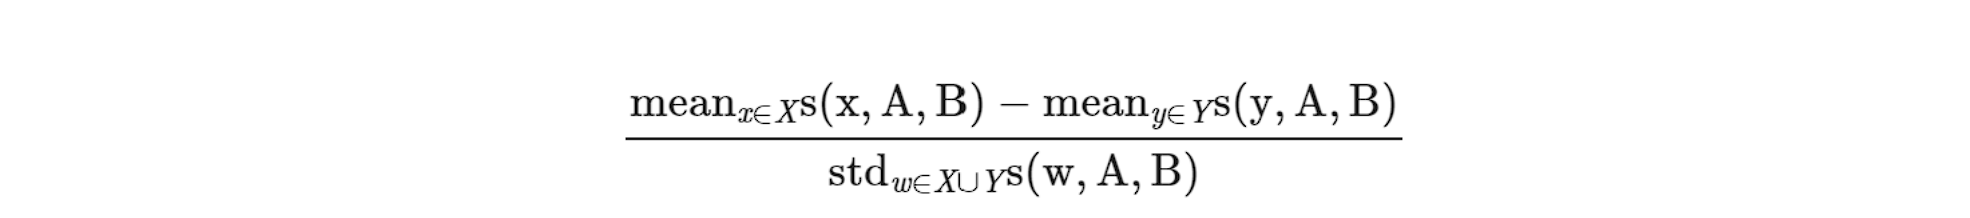


* 위 식에서 양수가 나오려면 극단적인 경우만 생각하면 s(x,A,B)의 평균은 양수, s(y,A,B)의 평균은 음수가 나와야 함.

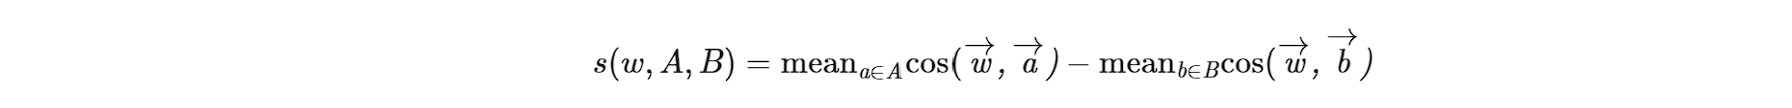

* s(x,A,B)가 양수가 나오려면 cos(x, a) 값이 양수 즉, x 와 a 벡터의 방향이 같고 cos(x, b) 값이 음수 즉, x 와 b 벡터의 방향이 반대여야 함. 혹은 양수가 나오더라도 cos(x, a) 평균 > cos(x, b) 평균 이어야 함.
* 이는 예술 영화(X)에 존재하는 단어벡터(x)와 코미디 영화(A)에 존재하는 단어벡터(a)와 방향이 같은 반면, 다큐멘터리(B)에 존재하는 단어벡터(b)와는 방향이 반대이거나 유사성이 거의 없어야 함을 의미함.
* s(y,A,B)가 음수가 나오려면, cos(y, a)가 음수 cos(y, b) 양수가 나와야 함. 즉, 일반 영화(Y)에 존재하는 단어벡터(y)와 코미디 영화(A)에 존재하는 단어벡터(a)와 방향이 다른 반면 다큐멘터리(B)에 존재하는 단어벡터(b)와는 방향이 같음을 의미함.


* 즉, 양수이므로 예술영화는 다큐멘터리보다 코미디와 상대적으로 더 가깝고, 일반영화는 코미디보다 다큐멘터리와 상대적으로 가깝다는 뜻


__2. 코미디-멜로로맨스 -0.9__ <br>
* 음수이므로 예술 영화는 코미디보다 멜로로맨스와 상대적으로 더 가깝고, 일반영화는 멜로로맨스보다 코미디와 상대적으로 더 가깝다는 뜻.

__3. 정리__<br>
* Weat score는 주어진 attribute대상 집합과 target 집합 사이의 __상대적__ 연관성 강도를 측정하는 것이기 때문에 절대적 지표를 나타내는 것이 아님. target 및 attribute 단어 집합과 사용된 다어 임베딩 공간에 따라 값은 달라질 수 있음.
* 즉, 코미디-다큐멘터리 가 attribute인 경우 다큐멘터리보다 코미디가 상대적으로 예술 영화와 연관성 강도가 높을 수 있고, 코미디-멜로로맨스가 attribute인 경우 코미디보다 멜로로맨스가 상대적으로 예술영화와 연관성 강도가 높을 수 있음을 의미함.

__4. 의문__<br>
* pca를 통해 차원을 축소시켜 시각화 했을 때 X, Y, A, B를 대표하는 단어 사이의 거리와 weat score간에 상관관계가 있을까?
* 시각화를 통해 X, Y, A, B를 대표하는 단어 분포를 확인해보자

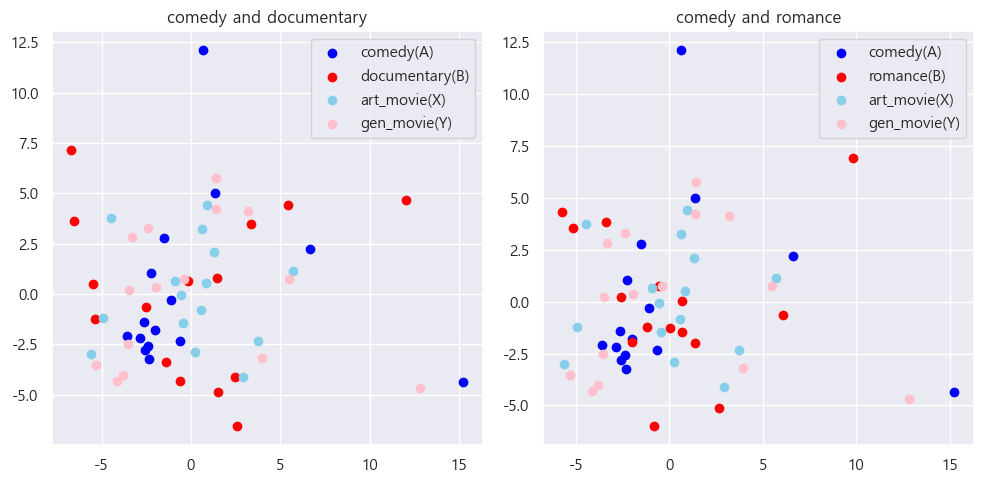

In [47]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# comedy and documentary
pca = PCA(n_components=2)
pc_X = pca.fit_transform(X)
pc_Y = pca.fit_transform(Y)
A = np.array([model.wv[word] for word in attributes[4]])
B = np.array([model.wv[word] for word in attributes[6]])
pc_A = pca.fit_transform(A)
pc_B = pca.fit_transform(B)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.scatter(pc_A[:, 0], pc_A[:, 1], c='blue', label='comedy(A)')
ax1.scatter(pc_B[:, 0], pc_B[:, 1], c='red', label='documentary(B)')
ax1.scatter(pc_X[:, 0], pc_X[:, 1], c='skyblue', label='art_movie(X)')
ax1.scatter(pc_Y[:, 0], pc_Y[:, 1], c='pink', label='gen_movie(Y)')
ax1.set_title('comedy and documentary')
ax1.legend()

# comedy and romance
pca = PCA(n_components=2)
pc_X = pca.fit_transform(X)
pc_Y = pca.fit_transform(Y)
A = np.array([model.wv[word] for word in attributes[4]])
B = np.array([model.wv[word] for word in attributes[15]])
pc_A = pca.fit_transform(A)
pc_B = pca.fit_transform(B)

ax2.scatter(pc_A[:, 0], pc_A[:, 1], c='blue', label='comedy(A)')
ax2.scatter(pc_B[:, 0], pc_B[:, 1], c='red', label='romance(B)')
ax2.scatter(pc_X[:, 0], pc_X[:, 1], c='skyblue', label='art_movie(X)')
ax2.scatter(pc_Y[:, 0], pc_Y[:, 1], c='pink', label='gen_movie(Y)')
ax2.set_title('comedy and romance')
ax2.legend()

plt.tight_layout()
plt.show()


* 다큐멘터리와 멜로로맨스를 나타내는 점은 빨간색.
* 두 장르를 대표하는 단어의 위치를 보면 다큐멘터리보다 멜로로맨스 단어들이 좀 더 X, Y 가 분포된 곳에 집약적으로 분포하고 있음.
* 다른 경우도 살펴보자. __어드벤처_애니메이션 0.87__, __어드벤처_가족 0.0065__

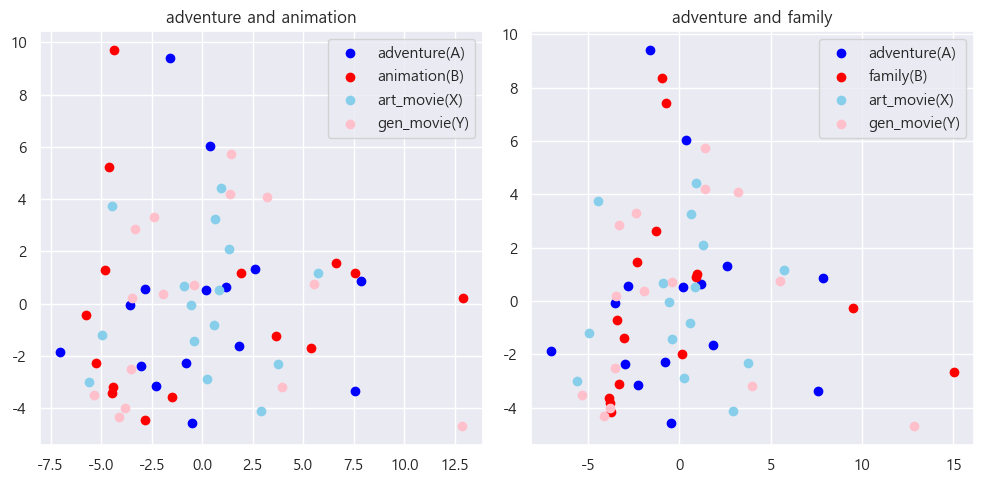

In [48]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# comedy and documentary
pca = PCA(n_components=2)
pc_X = pca.fit_transform(X)
pc_Y = pca.fit_transform(Y)
A = np.array([model.wv[word] for word in attributes[2]])
B = np.array([model.wv[word] for word in attributes[3]])
pc_A = pca.fit_transform(A)
pc_B = pca.fit_transform(B)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.scatter(pc_A[:, 0], pc_A[:, 1], c='blue', label='adventure(A)')
ax1.scatter(pc_B[:, 0], pc_B[:, 1], c='red', label='animation(B)')
ax1.scatter(pc_X[:, 0], pc_X[:, 1], c='skyblue', label='art_movie(X)')
ax1.scatter(pc_Y[:, 0], pc_Y[:, 1], c='pink', label='gen_movie(Y)')
ax1.set_title('adventure and animation')
ax1.legend()

# comedy and romance
pca = PCA(n_components=2)
pc_X = pca.fit_transform(X)
pc_Y = pca.fit_transform(Y)
A = np.array([model.wv[word] for word in attributes[2]])
B = np.array([model.wv[word] for word in attributes[9]])
pc_A = pca.fit_transform(A)
pc_B = pca.fit_transform(B)

ax2.scatter(pc_A[:, 0], pc_A[:, 1], c='blue', label='adventure(A)')
ax2.scatter(pc_B[:, 0], pc_B[:, 1], c='red', label='family(B)')
ax2.scatter(pc_X[:, 0], pc_X[:, 1], c='skyblue', label='art_movie(X)')
ax2.scatter(pc_Y[:, 0], pc_Y[:, 1], c='pink', label='gen_movie(Y)')
ax2.set_title('adventure and family')
ax2.legend()

plt.tight_layout()
plt.show()


* pca는 데이터 분포가 최대가 되는 주축과 주축에 직교하는 축을 생성해 각 축에 데이터를 사영하여 차원 축소를 진행함. 즉, 공분산 행렬의 고유벡터와 고유값을 이용해 선형변환을 수행해 2차원으로 차원을 축소시키기 때문에 위 plot에서 각 target과 attribute 사이의 거리가 가깝다는 이유로 각 attibute와 target의 연관성 강도가 높다고 하기에는 한계가 있다고 생각함.(극단적인 예로, P(1,1)과 P'(1.1, 100)을 x축으로 투영시켰을 때, P-P'의 거리는 0.1이 되지만, 1차원으로 축소하기 전 P-P' 거리는 약 99로 매우 멀기 때문.
* weat score는 거리 기반이 아닌, 두 벡터 사이의 사잇각 theta를 측정하는 cosine 유사도를 기반으로 함. 이 경우 P와P'의 코사인 유사도는 매우 높음.
* 즉, pca로 차원축소 후 나타난 각 point들 사이의 거리와 weat score는 서로 관련이 없음.

__5. etc__<br>
* Weat score의 최대 최소 값 범위는 -2 ~ 2임. 그러나 위 heatmap을 보면 -1 ~ 1 사이의 값밖에 없음.
* 승현님은 wordvector를 만들 때 sg=0이 아닌, 1 즉, skipgram을 이용하셨는데, 이때 값이 최대 1.8 정도 나오는 것을 확인하셨다고 함.
* 은정님은 중복 단어를 제거하고 Weat score를 계산해보셨을 때 값의 범위가 조금 넓어지고, 경향이 많이 바뀌는 카테고리가 있다고 하셨으나, 전반적인 weat score 경향은 크게 변화가 없다고 하심.
* wordvector를 만들 때 어떤 방식을 사용하느냐에 따라, 혹은 중복 단어 처리 유무에 따라 편향도의 수치가 변화한다는 것을 다른 그루 분들의 실험을 통해 알 수 있었음.
* target과 attribute간 연관성 강도를 weat score로 측정하기에 적합하지 않은 데이터셋이라고 생각함.
* 상업영화라고 특정지은 general_movie와 예술영화라고 특정지은 art_movie가 다른 장르의 영화를 구분짓기에는 특성이 명확하지 않다고 생각함.